## Imports and Preliminaries

In [22]:
%matplotlib inline
from typing import List, Optional, Callable, Iterator
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from torch.utils.data import DataLoader, Dataset, Subset

sns.set_style("whitegrid")

# !pip install timm
import timm

def accuracy(target, pred):
    return accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def show_image(img, title=None):
    # img = img.detach().cpu()
    img = img.permute((1, 2, 0)).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean   # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.gca().tick_params(axis="both", which="both", bottom=False, left=False, labelbottom=False, labelleft=False)
    if title is not None:
        plt.title(title)

## Dataset Class

In [33]:
from pathlib import Path
from PIL import Image
from torchvision import transforms


class MVTecDataset(Dataset):
    def __init__(self, root_dir, category, split='train', transform=None):
        """
        Args:
            root_dir: Path to MVTec AD dataset root
            category: Product category (e.g., 'bottle', 'cable', 'capsule')
            split: 'train' or 'test'
            transform: Preprocessing transforms
        """
        self.root_dir = Path(root_dir)
        self.category = category
        self.split = split
        self.transform = transform
        
        # Build image paths
        self.image_paths = []
        self.labels = []
        self.defect_types = []
        
        if split == 'train':
            # Training images are all normal
            train_dir = self.root_dir / category / 'train' / 'good'
            for img_path in sorted(train_dir.glob('*.png')):
                self.image_paths.append(img_path)
                self.labels.append(0)
                self.defect_types.append('good')
        else:
            # Test images include normal and anomalies
            test_dir = self.root_dir / category / 'test'
            for defect_dir in sorted(test_dir.iterdir()):
                if defect_dir.is_dir():
                    defect_type = defect_dir.name
                    print("defect type:", defect_type)
                    label = 0 if defect_type == 'good' else 1
                    
                    for img_path in sorted(defect_dir.glob('*.png')):
                        self.image_paths.append(img_path)
                        self.labels.append(label)
                        self.defect_types.append(defect_type)
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image, self.defect_types[idx]

        # return {
        #     'image': image,
        #     'label': self.labels[idx],
        #     'defect_type': self.defect_types[idx],
        #     'path': str(img_path)
        # }

## Create Datasets

In [34]:
MVTEC_ROOT = './Dataset' 
CATEGORY = 'cable'
BATCH_SIZE = 16
IMAGE_SIZE = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def get_transforms(image_size=224, mean=imagenet_mean, std=imagenet_std):
    return transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=mean,
            std=std
        )
    ])


transform = get_transforms(IMAGE_SIZE)

train_dataset = MVTecDataset(
    root_dir=MVTEC_ROOT,
    category=CATEGORY,
    split='train',
    transform=transform
)

test_dataset = MVTecDataset(
    root_dir=MVTEC_ROOT,
    category=CATEGORY,
    split='test',
    transform=transform
)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    # pin_memory=True
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    # pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

defect type: bent_wire
defect type: cable_swap
defect type: combined
defect type: cut_inner_insulation
defect type: cut_outer_insulation
defect type: good
defect type: missing_cable
defect type: missing_wire
defect type: poke_insulation
Training samples: 224
Test samples: 150


TRAINING IMAGES


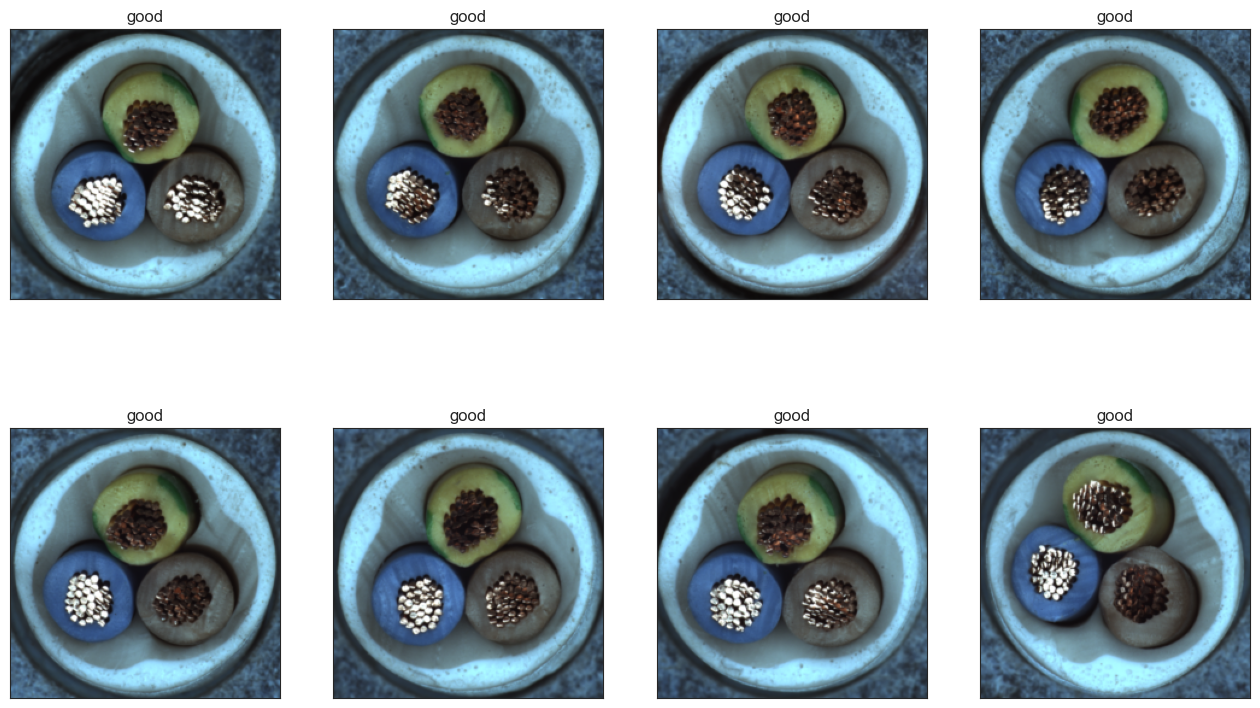

TESTING IMAGES


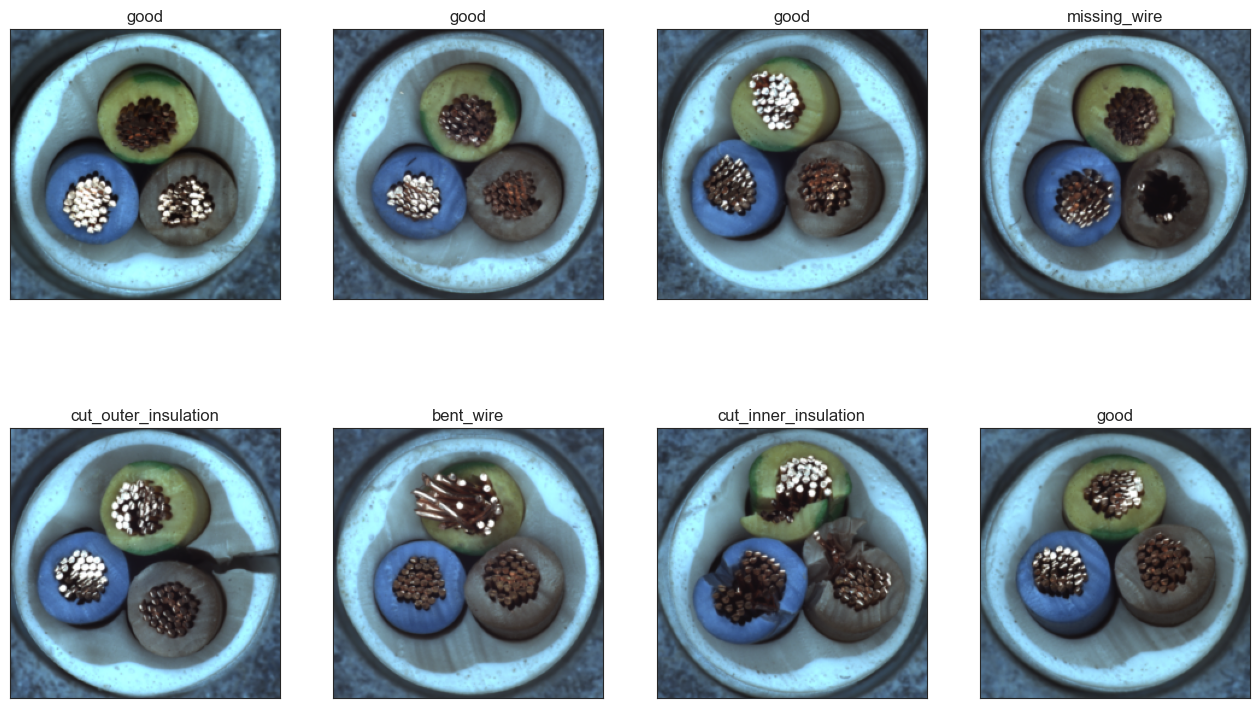

In [39]:

def show_dataset_examples(dataloader):
    images, labels = next(iter(dataloader))
    with sns.axes_style("white"):
      fig, axes = plt.subplots(2, 4, figsize=(16, 9.5))
    axes = [ax for axes_ in axes for ax in axes_]   # flatten
    for j, (img, label) in enumerate(zip(images[:8], labels[:8])):
        plt.sca(axes[j])
        show_image(img, label)
    plt.show()

print("TRAINING IMAGES")
show_dataset_examples(train_loader)
print("TESTING IMAGES")
show_dataset_examples(test_loader)